In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

#%pdb

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd

def loadfile(mean, var, zmean, zvar, tau, temp, mixtures, model, data_size = "full",  scaling = False, model_save_dir = "", fn="", file = "res"):
    s = "s" if scaling else "f" 
    exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}_{}".format(model, mean, zmean, 50, tau, int(mixtures), int(temp), s, data_size) + fn
    if (file=='res'):
        with open(model_save_dir + '/mnist_retrain_res_{}.p'.format(exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='gmp'):
        with open(model_save_dir + '/mnist_retrain_gmp_{}.p'.format(exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='model'):
        file = torch.load(model_save_dir + '/mnist_retrain_model_{}.m'.format(exp_name))
    return file

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [13]:
c_exp = pd.DataFrame(columns = ["method", "temp", "tau", "acc", "sp"])
idx=0
temp_list = [1, 2, 4, 5, 6, 8]
tau_list = [5e-6, 2e-6, 1e-6, 5e-7, 2e-7, 1e-7]
for temp in temp_list:
    for tau in tau_list:
        res = loadfile(250, 10, 2500, 1250, tau, temp, 16, "LeNet_300_100", model_save_dir = "./vastkd/files")
        c_exp.loc[idx] = (["KD MSE", temp, tau, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1
        
temp_list = [1, 2, 4, 5, 6, 8]
tau_list = [5e-5, 2e-5, 1e-5, 5e-6, 2e-6, 1e-6]
for temp in temp_list:
    for tau in tau_list:
        res = loadfile(1000, 0.1, 5000, 1000, tau, temp, 16, "LeNet_300_100", model_save_dir = "./kd/files")
        c_exp.loc[idx] = (["KD CE", temp, tau, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1
        
taulist = [1e-5, 2e-5, 5e-6, 2e-6, 5e-7, 2e-7, 1e-7, 5e-8, 1e-6]
for tau in taulist:
    res = loadfile(1, 0.1, 1000, 1000, tau, int(0), 16, "LeNet_300_100", model_save_dir = "./sws/files")
    c_exp.loc[idx] = (["SWS", int(0), tau, res["prune_acc"]["test"], res["sparsity"]])
    idx+=1

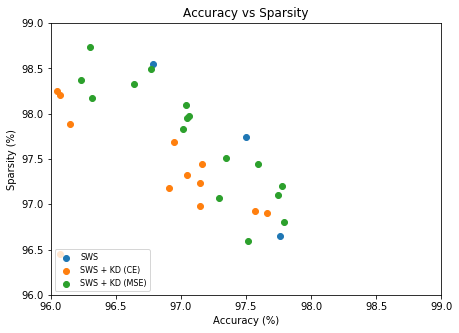

In [39]:
plt.figure(figsize=(7,5))
sws_scatter = plt.scatter(c_exp.query('method == \'SWS\'')['acc'], c_exp.query('method == \'SWS\'')['sp'])
kd_ce_scatter = plt.scatter(c_exp.query('method == \'KD CE\'')['acc'], c_exp.query('method == \'KD CE\'')['sp'])
kd_mse_scatter = plt.scatter(c_exp.query('method == \'KD MSE\'')['acc'], c_exp.query('method == \'KD MSE\'')['sp'])
plt.title("Accuracy vs Sparsity")
plt.xlabel("Accuracy (%)")
plt.ylabel("Sparsity (%)")
plt.legend((sws_scatter, kd_ce_scatter, kd_mse_scatter), ('SWS', "SWS + KD (CE)", "SWS + KD (MSE)"), scatterpoints=1, loc='lower left', ncol=1, fontsize=8)
plt.xlim([96,99])
plt.ylim([96,99])
plt.savefig('figs/accvsp.eps', format='eps', dpi=600)
plt.show()

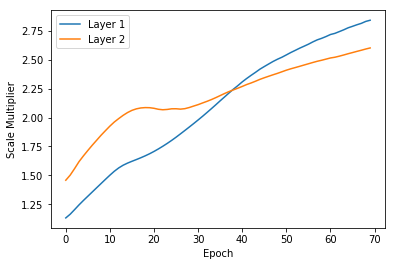

In [38]:

with open('./scaling/files/mnist_retrain_res_LeNet_300_100_m1000_zm5000_r90_t2e-05_m16_kdT5_s_full_CE.p','rb') as f:
    res_s = pickle.load(f)
plt.plot(res_s['scale'][:70,0], label="Layer 1")
plt.plot(res_s['scale'][:70,1], label="Layer 2")
plt.legend()
plt.ylabel('Scale Multiplier')
plt.xlabel('Epoch')
plt.savefig('figs/sws_scale.eps', format='eps', dpi=600)
plt.show()